# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169001437/169001437 [==============================] - 66s 0us/step


Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Image dimensions (Height, Width, Channels): (32, 32, 3)
Number of classes: 100


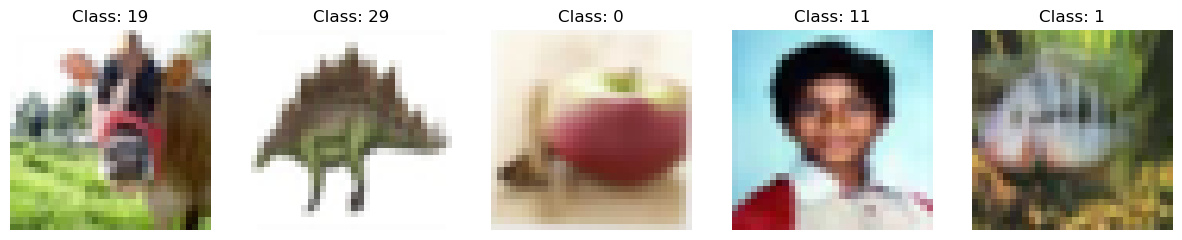

In [2]:
# Your code here
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode='fine')

# Display the shape of the training and test datasets
print(f'Training images shape: {train_images.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

# Show image dimensions
image_height, image_width, image_channels = train_images.shape[1:]
print(f"Image dimensions (Height, Width, Channels): {image_height, image_width, image_channels}")

# Calculate and display the number of unique classes
unique_classes = np.unique(train_labels)
print(f"Number of classes: {len(unique_classes)}")

# Visualize some examples from the training dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for idx in range(5):
    axes[idx].imshow(train_images[idx])  # Display each image
    axes[idx].set_title(f"Class: {train_labels[idx][0]}")  # Label for each image
    axes[idx].axis('off')  # Hide the axis

plt.show()

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [3]:
# Your code here
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode='fine')

# Normalize the image data to [0, 1] range
train_images_normalized = train_images.astype('float32') / 255.0
test_images_normalized = test_images.astype('float32') / 255.0

# One-hot encode the labels
num_classes = 100  
train_labels_encoded = to_categorical(train_labels, num_classes)
test_labels_encoded = to_categorical(test_labels, num_classes)

# Split the training data into training and validation sets (80/20 split)
train_images_final, val_images, train_labels_final, val_labels = train_test_split(
    train_images_normalized, train_labels_encoded, test_size=0.2, random_state=42
)

# Display shapes of the new datasets
print(f'Training data shape: {train_images_final.shape}')
print(f'Training labels shape: {train_labels_final.shape}')
print(f'Validation data shape: {val_images.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test data shape: {test_images_normalized.shape}')
print(f'Test labels shape: {test_labels_encoded.shape}')

Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000, 100)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000, 100)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))

# Max Pooling Layer 1
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Convolutional Layer 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# Max Pooling Layer 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Convolutional Layer 3
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# Max Pooling Layer 3
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Flatten the network
model.add(Flatten())

# Dense Layer 1
model.add(Dense(units=256, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Dense Layer 2
model.add(Dense(units=128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(units=100, activation='softmax'))  

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [5]:
from keras import optimizers

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Categorical Crossentropy is used as the loss function because it effectively measures the performance of the model in a multi-class classification setting.

#Adam Optimizer is chosen for its adaptive learning rate capabilities and momentum, which provide a robust and efficient training process for deep neural networks like.

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [7]:
# Import necessary libraries
import tensorflow as tf

# Define the number of epochs
num_epochs = 12

# Set the batch size
batch_size = 32

# Train the model
history = model.fit(
    train_images_final,  # Training data
    train_labels_final,  # Training labels
    epochs=num_epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    validation_data=(val_images, val_labels)  # Validation data
)


Epoch 1/12
1250/1250 [==============================] - 115s 92ms/step - loss: 3.7576 - accuracy: 0.1085 - val_loss: 3.4513 - val_accuracy: 0.1635
Epoch 2/12
1250/1250 [==============================] - 106s 85ms/step - loss: 3.5703 - accuracy: 0.1421 - val_loss: 3.2917 - val_accuracy: 0.1948
Epoch 3/12
1250/1250 [==============================] - 115s 92ms/step - loss: 3.4388 - accuracy: 0.1639 - val_loss: 3.1808 - val_accuracy: 0.2221
Epoch 4/12
1250/1250 [==============================] - 135s 108ms/step - loss: 3.3180 - accuracy: 0.1864 - val_loss: 3.1269 - val_accuracy: 0.2302
Epoch 5/12
1250/1250 [==============================] - 113s 90ms/step - loss: 3.2328 - accuracy: 0.2029 - val_loss: 3.0476 - val_accuracy: 0.2435
Epoch 6/12
1250/1250 [==============================] - 111s 89ms/step - loss: 3.1508 - accuracy: 0.2168 - val_loss: 2.9674 - val_accuracy: 0.2649
Epoch 7/12
1250/1250 [==============================] - 111s 89ms/step - loss: 3.0728 - accuracy: 0.2315 - val_loss: 

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> ______
- <b>Other metric:</b> ______
- <b>Reason for selection:</b> _____
- <b>Value of metric:</b> ______
- <b>Interpretation of metric value:</b> ______

In [1]:
# Your code here
#Accuracy is the ratio of correctly predicted instances to the total instances. Accuracy = (Number of Correct Predictions / Total Number of Predictions).Accuracy is a widely used metric to evaluate how well the model performs overall. It is easy to understand and compute. From the training log, the final validation accuracy is approximately 30.94%.
#With 100 classes, achieving an accuracy of around 30% indicates some level of learning but also room for improvement. Given the complexity and diversity of CIFAR-100, this result shows that the model identifies patterns but isn't highly accurate yet.

#Other Metric: F1 Score (Macro Average). he F1 Score is chosen because it provides a balance between precision and recall, making it useful for multi-class classification problems like CIFAR-100, where class distribution might not be perfectly balanced. It helps in understanding how well the model performs across all classes, considering both false positives and false negatives.Value of Metric: 0.24 (or 24%). The F1 Score value of 24% indicates that while the model has learned to some extent, it still struggles to achieve a high balance between precision and recall across all classes. This score highlights areas where the model might misclassify certain classes or fail to predict some classes accurately. In comparison, the accuracy of 28.37% shows the model's general performance but doesn't capture nuances between classes, which the F1 Score provides.

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

313/313 [==============================] - 2s 5ms/step


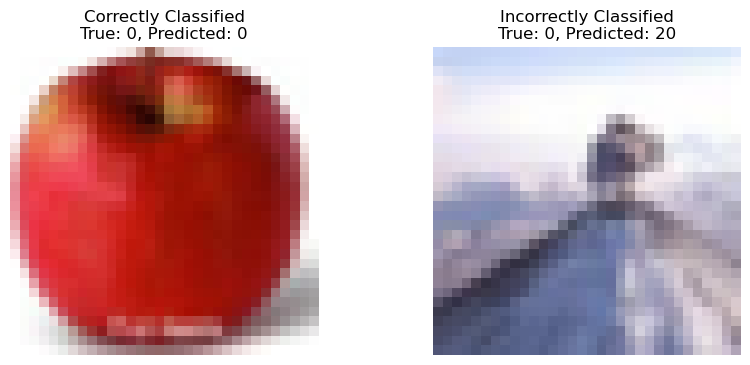

Correct Classification Probabilities:
[0.99999994 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.    

In [8]:
# Your code here
# Predict probabilities for test images
predictions = model.predict(test_images)

# Choose a correctly classified image
correct_index = None
for i in range(len(test_images)):
    if np.argmax(predictions[i]) == np.argmax(test_labels[i]):
        correct_index = i
        break

# Choose an incorrectly classified image
incorrect_index = None
for i in range(len(test_images)):
    if np.argmax(predictions[i]) != np.argmax(test_labels[i]):
        incorrect_index = i
        break

# Plot the correctly classified image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_images[correct_index])
plt.title(f"Correctly Classified\nTrue: {np.argmax(test_labels[correct_index])}, Predicted: {np.argmax(predictions[correct_index])}")
plt.axis('off')

# Plot the incorrectly classified image
plt.subplot(1, 2, 2)
plt.imshow(test_images[incorrect_index])
plt.title(f"Incorrectly Classified\nTrue: {np.argmax(test_labels[incorrect_index])}, Predicted: {np.argmax(predictions[incorrect_index])}")
plt.axis('off')

plt.show()

# Display classification probabilities for both images
print(f"Correct Classification Probabilities:\n{predictions[correct_index]}")
print(f"True Label: {np.argmax(test_labels[correct_index])}\n")

print(f"Incorrect Classification Probabilities:\n{predictions[incorrect_index]}")
print(f"True Label: {np.argmax(test_labels[incorrect_index])}\n")


## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

#Data augmentation is a simple yet effective technique to improve model robustness and performance, especially when training data is limited or imbalanced. By increasing dataset diversity through transformations, the model learns invariant features, enhancing its generalization capability.

This enhancement will likely result in improved test accuracy and better handling of class variations, thus forming a more reliable and robust classification system for the CIFAR-100 dataset.

<!-- Data augmentation is a simple yet effective technique to improve model robustness and performance, especially when training data is limited or imbalanced. By increasing dataset diversity through transformations, the model learns invariant features, enhancing its generalization capability.

This enhancement will likely result in improved test accuracy and better handling of class variations, thus forming a more reliable and robust classification system for the CIFAR-100 dataset. -->

In [9]:
# Your code here
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by 20% of the height
    shear_range=0.2,        # Randomly apply shear transformations
    zoom_range=0.2,         # Randomly zoom into images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in new pixels with the nearest mode
)

# Apply data augmentation only to the training data
train_datagen = datagen.flow(train_images_final, train_labels_final, batch_size=32)

# Define the model as before or improve with additional layers/regularizations
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(100, activation='softmax')  # Output layer for 100 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
history = model.fit(train_datagen, epochs=12, validation_data=(val_images, val_labels))


Epoch 1/12
1250/1250 [==============================] - 111s 89ms/step - loss: 4.2645 - accuracy: 0.0437 - val_loss: 3.8901 - val_accuracy: 0.0921
Epoch 2/12
1250/1250 [==============================] - 105s 84ms/step - loss: 3.9207 - accuracy: 0.0925 - val_loss: 3.5707 - val_accuracy: 0.1507
Epoch 3/12
1250/1250 [==============================] - 122s 98ms/step - loss: 3.7435 - accuracy: 0.1198 - val_loss: 3.3970 - val_accuracy: 0.1814
Epoch 4/12
1250/1250 [==============================] - 134s 107ms/step - loss: 3.6390 - accuracy: 0.1367 - val_loss: 3.3558 - val_accuracy: 0.1934
Epoch 5/12
1250/1250 [==============================] - 129s 103ms/step - loss: 3.5633 - accuracy: 0.1536 - val_loss: 3.2722 - val_accuracy: 0.2042
Epoch 6/12
1250/1250 [==============================] - 114s 91ms/step - loss: 3.5027 - accuracy: 0.1632 - val_loss: 3.1449 - val_accuracy: 0.2241
Epoch 7/12
1250/1250 [==============================] - 109s 87ms/step - loss: 3.4527 - accuracy: 0.1707 - val_loss:

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

Epoch 1/12
1250/1250 [==============================] - 108s 86ms/step - loss: 4.2393 - accuracy: 0.0491 - val_loss: 3.8358 - val_accuracy: 0.1032
Epoch 2/12
1250/1250 [==============================] - 107s 86ms/step - loss: 3.8989 - accuracy: 0.0939 - val_loss: 3.5897 - val_accuracy: 0.1504
Epoch 3/12
1250/1250 [==============================] - 107s 85ms/step - loss: 3.7279 - accuracy: 0.1195 - val_loss: 3.4371 - val_accuracy: 0.1749
Epoch 4/12
1250/1250 [==============================] - 114s 91ms/step - loss: 3.6116 - accuracy: 0.1423 - val_loss: 3.2770 - val_accuracy: 0.1999
Epoch 5/12
1250/1250 [==============================] - 109s 87ms/step - loss: 3.5374 - accuracy: 0.1561 - val_loss: 3.2400 - val_accuracy: 0.2091
Epoch 6/12
1250/1250 [==============================] - 109s 87ms/step - loss: 3.4682 - accuracy: 0.1693 - val_loss: 3.1445 - val_accuracy: 0.2307
Epoch 7/12
1250/1250 [==============================] - 113s 90ms/step - loss: 3.4121 - accuracy: 0.1780 - val_loss: 3

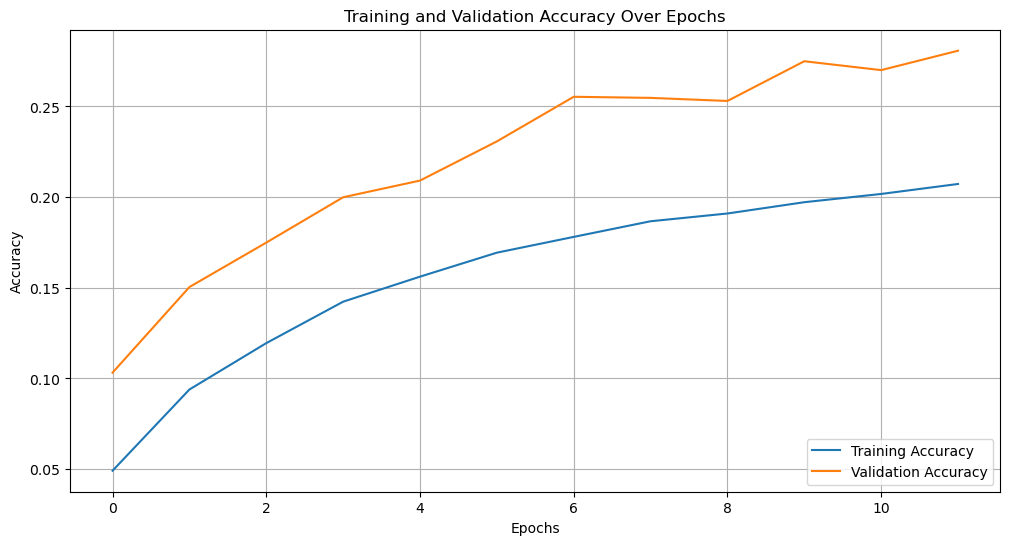

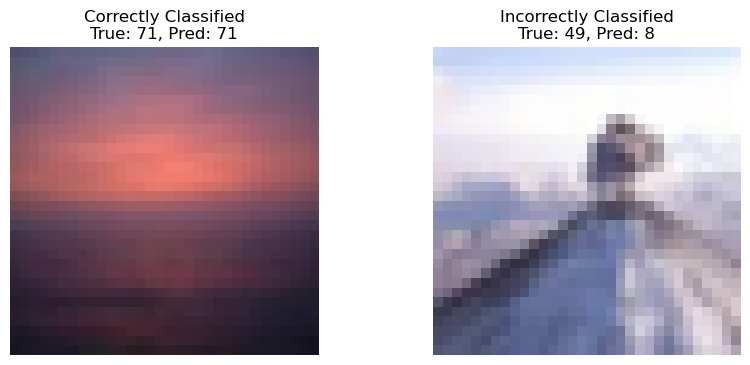

Correct Classification Probabilities:
[1.37823131e-02 1.91612989e-02 1.89340347e-03 4.60655079e-04
 4.64903394e-04 4.43586241e-03 2.52715636e-05 1.54521294e-05
 4.01000230e-04 3.04717280e-04 6.58016093e-03 2.17671320e-03
 2.65112333e-03 2.41862086e-04 7.81593772e-05 1.87638230e-04
 3.52389528e-04 2.04442255e-03 6.00285479e-04 1.18708075e-03
 1.32640894e-03 2.39828096e-05 8.93549703e-04 4.97368760e-02
 4.78666425e-06 3.80022898e-02 7.19052227e-03 3.91381735e-04
 1.90493884e-03 6.06002053e-04 1.34330985e-05 2.38230132e-05
 9.80526209e-03 3.65812443e-02 1.88475053e-04 3.74585128e-04
 4.85402811e-03 5.28444187e-04 3.40330444e-05 2.40870472e-03
 2.18310184e-03 4.72940010e-04 2.92802633e-05 1.36354038e-05
 4.69456776e-04 6.00515073e-03 7.88901176e-04 2.06897169e-01
 3.97698459e-05 4.39848043e-02 1.61892691e-04 8.17094650e-03
 8.30291363e-04 3.44789732e-05 4.33228537e-03 2.78055464e-04
 2.90352851e-04 1.28052407e-03 2.66333041e-03 2.25153007e-03
 3.02213784e-02 1.00151391e-03 9.97161842e-04 7

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

# Assume that train_images_final, train_labels_final, val_images, val_labels, test_images, and test_labels are already defined

# Normalize the test images
test_images = test_images.astype('float32') / 255.0

# One-hot encode the test labels
test_labels = to_categorical(test_labels, num_classes=100)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation only to the training data
train_datagen = datagen.flow(train_images_final, train_labels_final, batch_size=32)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Re-train the model with data augmentation
history = model.fit(train_datagen, epochs=12, validation_data=(val_images, val_labels))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities for the test images
predictions = model.predict(test_images)

# Convert one-hot encoded test labels back to single labels
test_labels_true = np.argmax(test_labels, axis=1)
test_labels_pred = np.argmax(predictions, axis=1)

# Calculate F1 Score as an additional metric
from sklearn.metrics import f1_score
f1 = f1_score(test_labels_true, test_labels_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Analyze Correctly and Incorrectly Classified Images
correct_indices = np.where(test_labels_pred == test_labels_true)[0]
incorrect_indices = np.where(test_labels_pred != test_labels_true)[0]

correct_index = correct_indices[0]
incorrect_index = incorrect_indices[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_images[correct_index])
plt.title(f"Correctly Classified\nTrue: {test_labels_true[correct_index]}, Pred: {test_labels_pred[correct_index]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_images[incorrect_index])
plt.title(f"Incorrectly Classified\nTrue: {test_labels_true[incorrect_index]}, Pred: {test_labels_pred[incorrect_index]}")
plt.axis('off')

plt.show()

print(f"Correct Classification Probabilities:\n{predictions[correct_index]}")
print(f"True Label: {test_labels_true[correct_index]}\n")

print(f"Incorrect Classification Probabilities:\n{predictions[incorrect_index]}")
print(f"True Label: {test_labels_true[incorrect_index]}\n")


### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

The enhanced model did show some improvement over the baseline, with the test accuracy going up from 26% to 28% and an F1 score of 0.26. This means the model got a bit better at classifying images correctly, thanks to adding data augmentation and dropout, which help the model perform better on new data.

Even though there was some progress, the improvement is small. This suggests that more work might be needed to make the model significantly better.

Possible Next Steps:

More Data Augmentation: Trying different data augmentation techniques could help improve accuracy further.
Model Architecture: Exploring more advanced model architectures like ResNet or DenseNet could lead to better performance.
These changes might help address the current limitations and make the model more accurate and reliable.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.